##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). The dataset comes with an inbuilt subword tokenizer.


In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

As this is a subwords tokenizer, it can be passed any string and the tokenizer will tokenize it.

In [0]:
tokenizer = info.features['text'].encoder

In [0]:
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [0]:
sample_string = 'TensorFlow is cool.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
The original string: TensorFlow is cool.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [0]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
4265 ----> ow
9 ----> is
2724 ----> cool
7975 ----> .


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 75s 191ms/step - loss: 0.5536 - accuracy: 0.7140 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 73s 187ms/step - loss: 0.3922 - accuracy: 0.8311 - val_loss: 0.5141 - val_accuracy: 0.7940
Epoch 3/10
391/391 [==============================] - 71s 182ms/step - loss: 0.3120 - accuracy: 0.8807 - val_loss: 0.4517 - val_accuracy: 0.8098
Epoch 4/10
391/391 [==============================] - 78s 199ms/step - loss: 0.2548 - accuracy: 0.9030 - val_loss: 0.4383 - val_accuracy: 0.8235
Epoch 5/10
391/391 [==============================] - 72s 185ms/step - loss: 0.2387 - accuracy: 0.9078 - val_loss: 0.4918 - val_accuracy: 0.8214
Epoch 6/10
391/391 [==============================] - 71s 182ms/step - loss: 0.1905 - accuracy: 0.9293 - val_loss: 0.4849 - val_accuracy: 0.8162
Epoch 7/10
391/391 [==============================] - 71s 182ms/step - loss: 0.1900 - accuracy: 0.9282 - val_loss: 0.5919 

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 19s 47ms/step - loss: 0.5533 - accuracy: 0.7873Test Loss: 0.553319326714
Test Accuracy: 0.787320017815


The above model does not mask the padding applied to the sequences. This can lead to skewness if we train on padded sequences and test on un-padded sequences. Ideally the model would learn to ignore the padding, but as you can see below it does have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sentence, pad):
  tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)

  if pad:
    tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)

  predictions = model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

  return (predictions)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[ 0.68914342]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[ 0.68634349]]


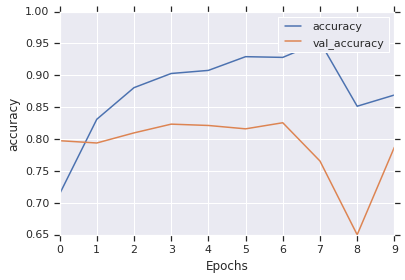

In [0]:
plot_graphs(history, 'accuracy')

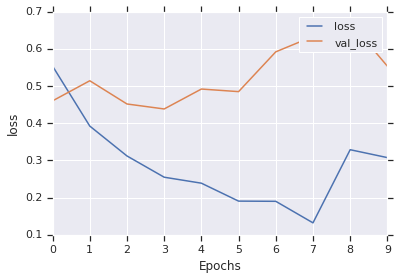

In [0]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 155s 397ms/step - loss: 0.6349 - accuracy: 0.6162 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 155s 396ms/step - loss: 0.6333 - accuracy: 0.6134 - val_loss: 0.5872 - val_accuracy: 0.6914
Epoch 3/10
391/391 [==============================] - 153s 391ms/step - loss: 0.4199 - accuracy: 0.8217 - val_loss: 0.4361 - val_accuracy: 0.8187
Epoch 4/10
391/391 [==============================] - 156s 398ms/step - loss: 0.3088 - accuracy: 0.8785 - val_loss: 0.4131 - val_accuracy: 0.8319
Epoch 5/10
391/391 [==============================] - 153s 391ms/step - loss: 0.3328 - accuracy: 0.8564 - val_loss: 0.4689 - val_accuracy: 0.7958
Epoch 6/10
391/391 [==============================] - 156s 398ms/step - loss: 0.2383 - accuracy: 0.9128 - val_loss: 0.4299 - val_accuracy: 0.8404
Epoch 7/10
391/391 [==============================] - 152s 388ms/step - loss: 0.2426 - accuracy: 0.9039 - val_loss: 

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 45s 115ms/step - loss: 0.5646 - accuracy: 0.8070Test Loss: 0.564571284348
Test Accuracy: 0.80703997612


In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[ 0.00393916]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[ 0.01098633]]


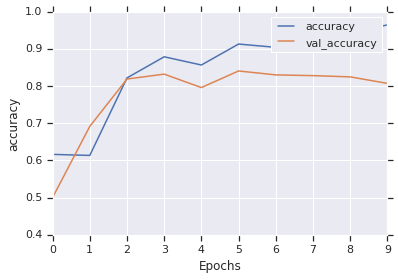

In [0]:
plot_graphs(history, 'accuracy')

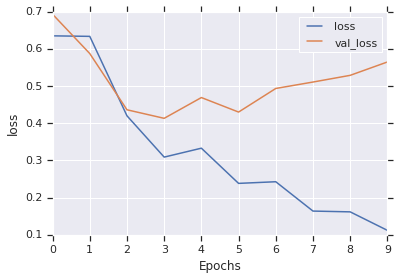

In [0]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).